# KE5105 - Building Electrical Consumption Forecasting

# Modelling 7 - Preliminary model

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

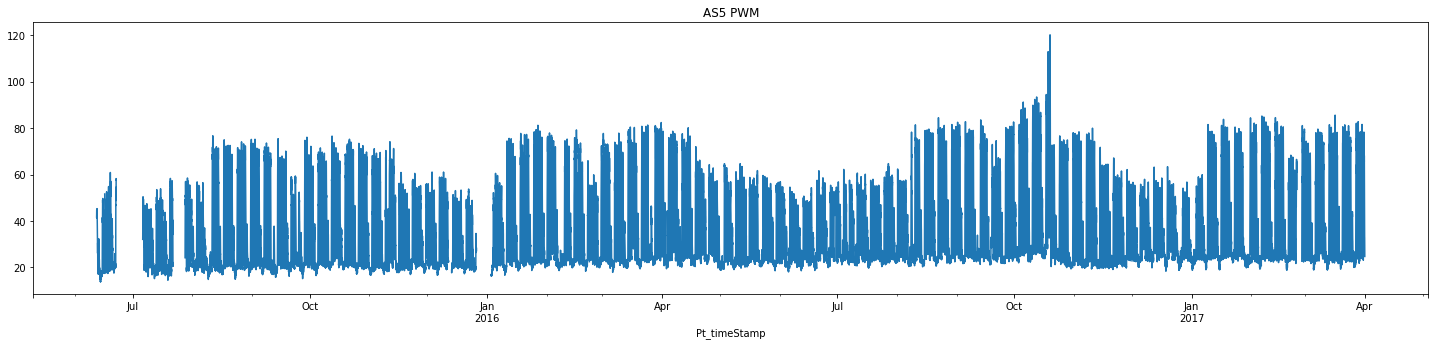

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

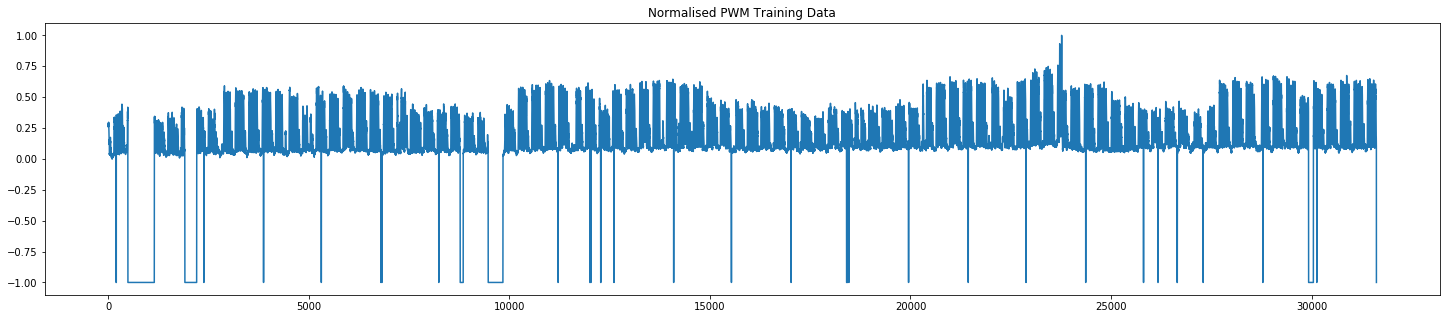

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

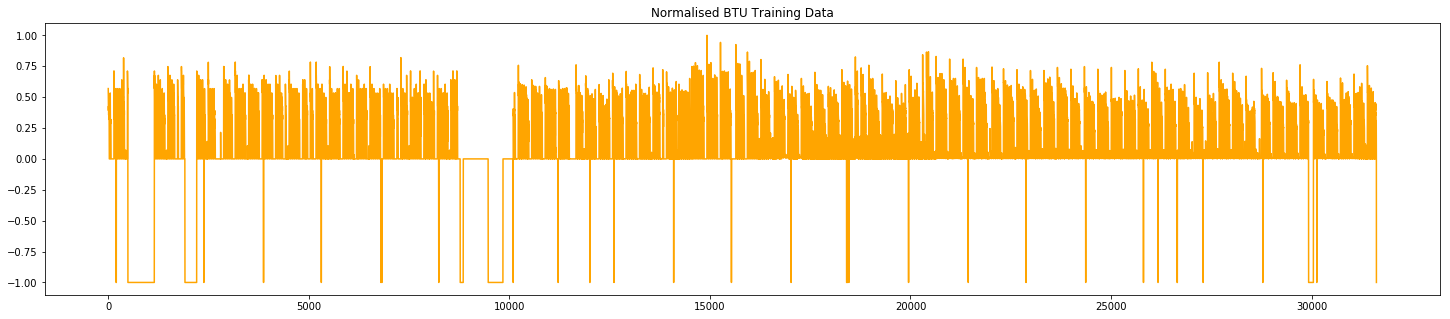

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and No Recurrent Dropout

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100-histories.pkl'), 'rb') as infile:
    history = pickle.load(infile)
histories = []
histories.append(history)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100.h5'))
model.summary()

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


Epoch 1/50


 - 86s - loss: 0.0171 - mean_absolute_percentage_error: 12.0224 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.9647


Epoch 2/50


 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.6243 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 15.3454


Epoch 3/50


 - 87s - loss: 0.0167 - mean_absolute_percentage_error: 11.6560 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 13.5094


Epoch 4/50


 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5926 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 11.5723


Epoch 5/50


 - 85s - loss: 0.0168 - mean_absolute_percentage_error: 11.5655 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.3368


Epoch 6/50


 - 85s - loss: 0.0164 - mean_absolute_percentage_error: 11.4245 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 15.7287


Epoch 7/50


 - 86s - loss: 0.0166 - mean_absolute_percentage_error: 11.5572 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 9.9357


Epoch 8/50


 - 85s - loss: 0.0165 - mean_absolute_percentage_error: 11.6128 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 14.1639


Epoch 9/50


 - 85s - loss: 0.0162 - mean_absolute_percentage_error: 11.2618 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 12.4204


Epoch 10/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.4064 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 15.9102


Epoch 11/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.5465 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 8.8550


Epoch 12/50


 - 85s - loss: 0.0162 - mean_absolute_percentage_error: 11.3691 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 11.2001


Epoch 13/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.4084 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 13.9207


Epoch 14/50


 - 84s - loss: 0.0162 - mean_absolute_percentage_error: 11.3452 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 9.7970


Epoch 15/50


 - 84s - loss: 0.0163 - mean_absolute_percentage_error: 11.1072 - val_loss: 0.0338 - val_mean_absolute_percentage_error: 13.8119


Epoch 16/50


 - 84s - loss: 0.0161 - mean_absolute_percentage_error: 11.2694 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 12.7980


Epoch 17/50


 - 84s - loss: 0.0160 - mean_absolute_percentage_error: 11.1229 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 15.7223


Epoch 18/50


 - 84s - loss: 0.0158 - mean_absolute_percentage_error: 10.8383 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 11.4082


Epoch 19/50


 - 86s - loss: 0.0160 - mean_absolute_percentage_error: 11.1387 - val_loss: 0.0311 - val_mean_absolute_percentage_error: 14.7594


Epoch 20/50


 - 85s - loss: 0.0159 - mean_absolute_percentage_error: 10.9104 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 15.7994


Epoch 21/50


 - 86s - loss: 0.0159 - mean_absolute_percentage_error: 10.9630 - val_loss: 0.0337 - val_mean_absolute_percentage_error: 16.4207


Epoch 22/50


 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8370 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 14.6143


Epoch 23/50


 - 86s - loss: 0.0157 - mean_absolute_percentage_error: 10.8283 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 9.9764


Epoch 24/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.8772 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 16.3037


Epoch 25/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.7708 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 12.9687


Epoch 26/50


 - 85s - loss: 0.0155 - mean_absolute_percentage_error: 10.7222 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 12.5671


Epoch 27/50


 - 85s - loss: 0.0154 - mean_absolute_percentage_error: 10.8116 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 10.7769


Epoch 28/50


 - 86s - loss: 0.0155 - mean_absolute_percentage_error: 10.8546 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 11.1032


Epoch 29/50


 - 86s - loss: 0.0154 - mean_absolute_percentage_error: 10.6270 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2243


Epoch 30/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.6831 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 11.6795


Epoch 31/50


 - 85s - loss: 0.0156 - mean_absolute_percentage_error: 10.7268 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 13.2367


Epoch 32/50


 - 84s - loss: 0.0154 - mean_absolute_percentage_error: 10.9631 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 14.3728


Epoch 33/50


 - 84s - loss: 0.0153 - mean_absolute_percentage_error: 10.9301 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.8011


Epoch 34/50


 - 84s - loss: 0.0149 - mean_absolute_percentage_error: 10.4653 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.2863


Epoch 35/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.5842 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 12.4111


Epoch 36/50


 - 86s - loss: 0.0149 - mean_absolute_percentage_error: 10.3829 - val_loss: 0.0344 - val_mean_absolute_percentage_error: 16.5277


Epoch 37/50


 - 86s - loss: 0.0150 - mean_absolute_percentage_error: 10.5014 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 15.3042


Epoch 38/50


 - 85s - loss: 0.0149 - mean_absolute_percentage_error: 10.3825 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 11.7497


Epoch 39/50


 - 85s - loss: 0.0150 - mean_absolute_percentage_error: 10.4764 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 15.9315


Epoch 40/50


 - 84s - loss: 0.0149 - mean_absolute_percentage_error: 10.4563 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 13.7804


Epoch 41/50


 - 85s - loss: 0.0149 - mean_absolute_percentage_error: 10.4704 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 10.2311


Epoch 42/50


 - 85s - loss: 0.0148 - mean_absolute_percentage_error: 10.3275 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 13.1201


Epoch 43/50


 - 85s - loss: 0.0148 - mean_absolute_percentage_error: 10.2230 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 13.8458


Epoch 44/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.2862 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 11.6548


Epoch 45/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.2231 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 11.8438


Epoch 46/50


 - 85s - loss: 0.0147 - mean_absolute_percentage_error: 10.1059 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 15.7759


Epoch 47/50


 - 86s - loss: 0.0146 - mean_absolute_percentage_error: 10.1955 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 16.0121


Epoch 48/50


 - 89s - loss: 0.0147 - mean_absolute_percentage_error: 10.2089 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 10.0641


Epoch 49/50


 - 85s - loss: 0.0145 - mean_absolute_percentage_error: 10.3086 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 12.2293


Epoch 50/50


 - 85s - loss: 0.0144 - mean_absolute_percentage_error: 10.0015 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 11.7964



Training Duration = 1:10:59.656404


In [44]:
# histories = [] # for first training session
histories.append(history.history)

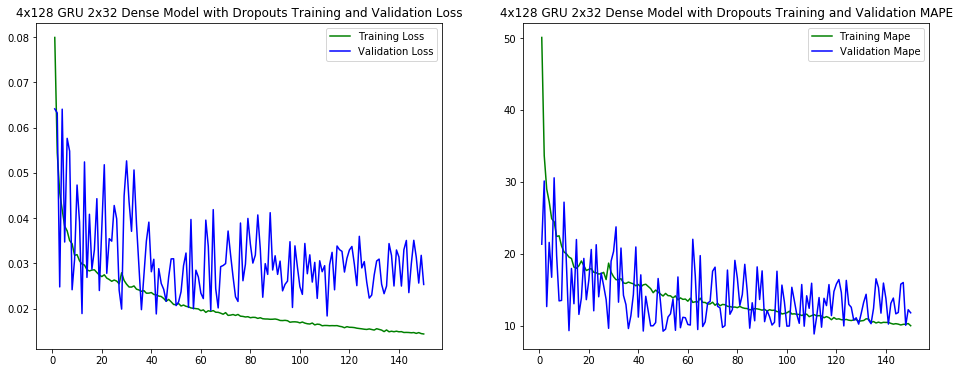

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.534367
Validation MAE = 2.505476


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

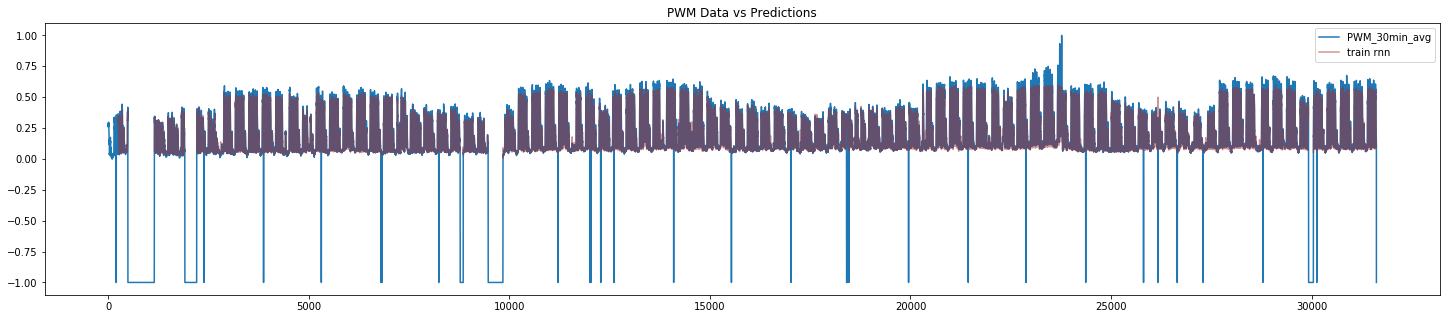

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

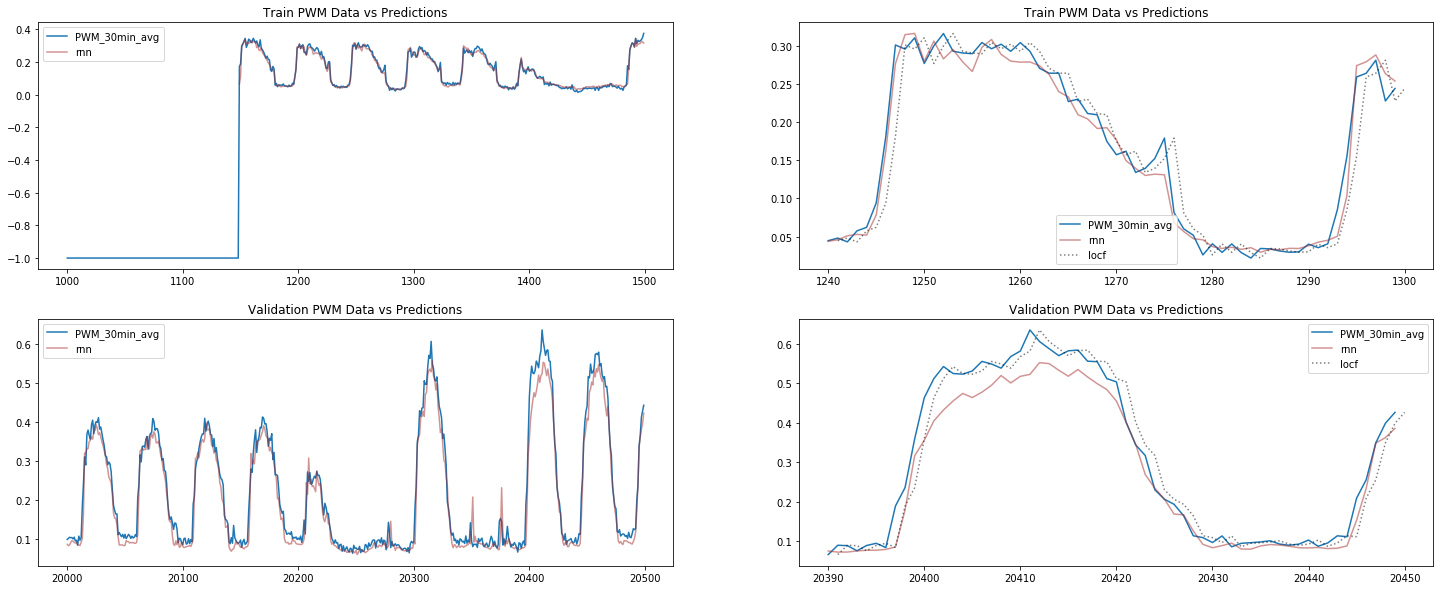

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0100.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0100-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with Dropout (0.1) and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.1, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [20]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [21]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [43]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50

 - 91s - loss: 0.0163 - mean_absolute_percentage_error: 10.9840 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 11.3677


Epoch 2/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1946 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.9685


Epoch 3/50


 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3835 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 11.0788


Epoch 4/50


 - 91s - loss: 0.0169 - mean_absolute_percentage_error: 11.3207 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 12.0514


Epoch 5/50


 - 92s - loss: 0.0168 - mean_absolute_percentage_error: 11.3684 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 11.6396


Epoch 6/50


 - 91s - loss: 0.0170 - mean_absolute_percentage_error: 11.2922 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 11.5798


Epoch 7/50


 - 91s - loss: 0.0167 - mean_absolute_percentage_error: 11.3904 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 16.8148


Epoch 8/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.2843 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 13.7214


Epoch 9/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.2352 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 14.9849


Epoch 10/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.1700 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 12.7072


Epoch 11/50


 - 91s - loss: 0.0167 - mean_absolute_percentage_error: 11.3324 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 9.9956


Epoch 12/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1086 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 14.3978


Epoch 13/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.2458 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 12.7129


Epoch 14/50


 - 92s - loss: 0.0167 - mean_absolute_percentage_error: 11.3283 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 15.1194


Epoch 15/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1945 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 11.6893


Epoch 16/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.3052 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 13.2164


Epoch 17/50


 - 92s - loss: 0.0165 - mean_absolute_percentage_error: 11.2098 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 11.7795


Epoch 18/50


 - 92s - loss: 0.0164 - mean_absolute_percentage_error: 11.1276 - val_loss: 0.0379 - val_mean_absolute_percentage_error: 15.9841


Epoch 19/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.0317 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.8110


Epoch 20/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.1411 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.8801


Epoch 21/50


 - 91s - loss: 0.0164 - mean_absolute_percentage_error: 11.0513 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.5305


Epoch 22/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0094 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 11.6019


Epoch 23/50


 - 92s - loss: 0.0166 - mean_absolute_percentage_error: 11.1456 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 12.1350


Epoch 24/50


 - 91s - loss: 0.0164 - mean_absolute_percentage_error: 11.0249 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 11.5897


Epoch 25/50


 - 90s - loss: 0.0163 - mean_absolute_percentage_error: 11.0044 - val_loss: 0.0347 - val_mean_absolute_percentage_error: 15.9830


Epoch 26/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.1297 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 11.5817


Epoch 27/50


 - 91s - loss: 0.0165 - mean_absolute_percentage_error: 11.1866 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 14.6732


Epoch 28/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0003 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 14.6257


Epoch 29/50


 - 94s - loss: 0.0163 - mean_absolute_percentage_error: 11.0808 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 12.4164


Epoch 30/50


 - 92s - loss: 0.0162 - mean_absolute_percentage_error: 10.9304 - val_loss: 0.0369 - val_mean_absolute_percentage_error: 16.6455


Epoch 31/50


 - 92s - loss: 0.0162 - mean_absolute_percentage_error: 10.9206 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 11.6015


Epoch 32/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 10.8892 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 15.1414


Epoch 33/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.8003 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 17.1724


Epoch 34/50


 - 90s - loss: 0.0162 - mean_absolute_percentage_error: 10.8903 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 13.2344


Epoch 35/50


 - 90s - loss: 0.0162 - mean_absolute_percentage_error: 10.9156 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 10.4738


Epoch 36/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0684 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 10.5141


Epoch 37/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.8931 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 10.7290


Epoch 38/50


 - 90s - loss: 0.0159 - mean_absolute_percentage_error: 10.6636 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 13.2502


Epoch 39/50


 - 90s - loss: 0.0160 - mean_absolute_percentage_error: 10.6485 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 14.8262


Epoch 40/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.6715 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 13.3752


Epoch 41/50


 - 91s - loss: 0.0162 - mean_absolute_percentage_error: 11.0826 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 12.2145


Epoch 42/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.5071 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 10.9936


Epoch 43/50


 - 92s - loss: 0.0155 - mean_absolute_percentage_error: 10.4958 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 12.2963


Epoch 44/50


 - 93s - loss: 0.0155 - mean_absolute_percentage_error: 10.4630 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.6791


Epoch 45/50


 - 91s - loss: 0.0156 - mean_absolute_percentage_error: 10.5832 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 11.9482


Epoch 46/50


 - 92s - loss: 0.0156 - mean_absolute_percentage_error: 10.5515 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 12.2829


Epoch 47/50


 - 95s - loss: 0.0156 - mean_absolute_percentage_error: 10.6616 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 16.3970


Epoch 48/50


 - 95s - loss: 0.0156 - mean_absolute_percentage_error: 10.6457 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 13.3019


Epoch 49/50


 - 96s - loss: 0.0155 - mean_absolute_percentage_error: 10.6110 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 10.0052


Epoch 50/50


 - 94s - loss: 0.0155 - mean_absolute_percentage_error: 10.4879 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 13.2090



Training Duration = 1:16:19.895959


In [44]:
# histories = []  # for first training session
histories.append(history.history)

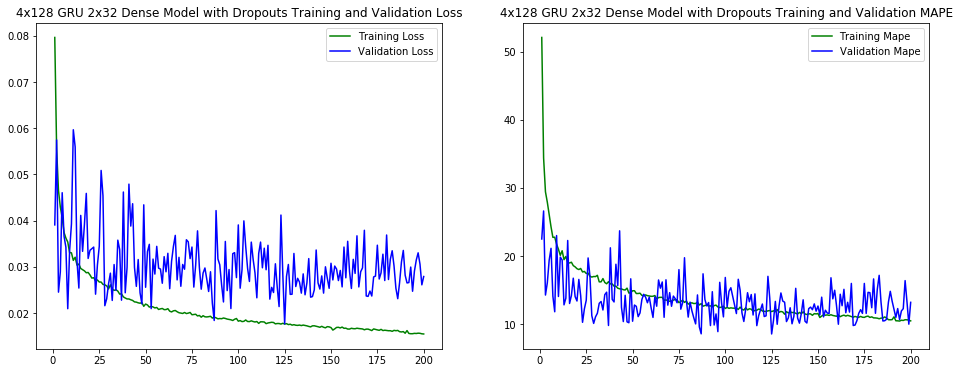

In [45]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [46]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.644406
Validation MAE = 2.628233


In [47]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [48]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

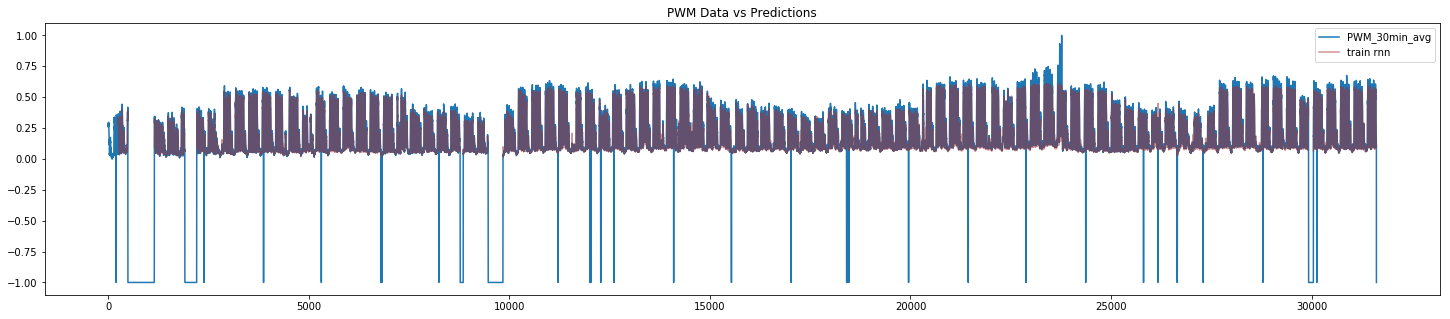

In [49]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

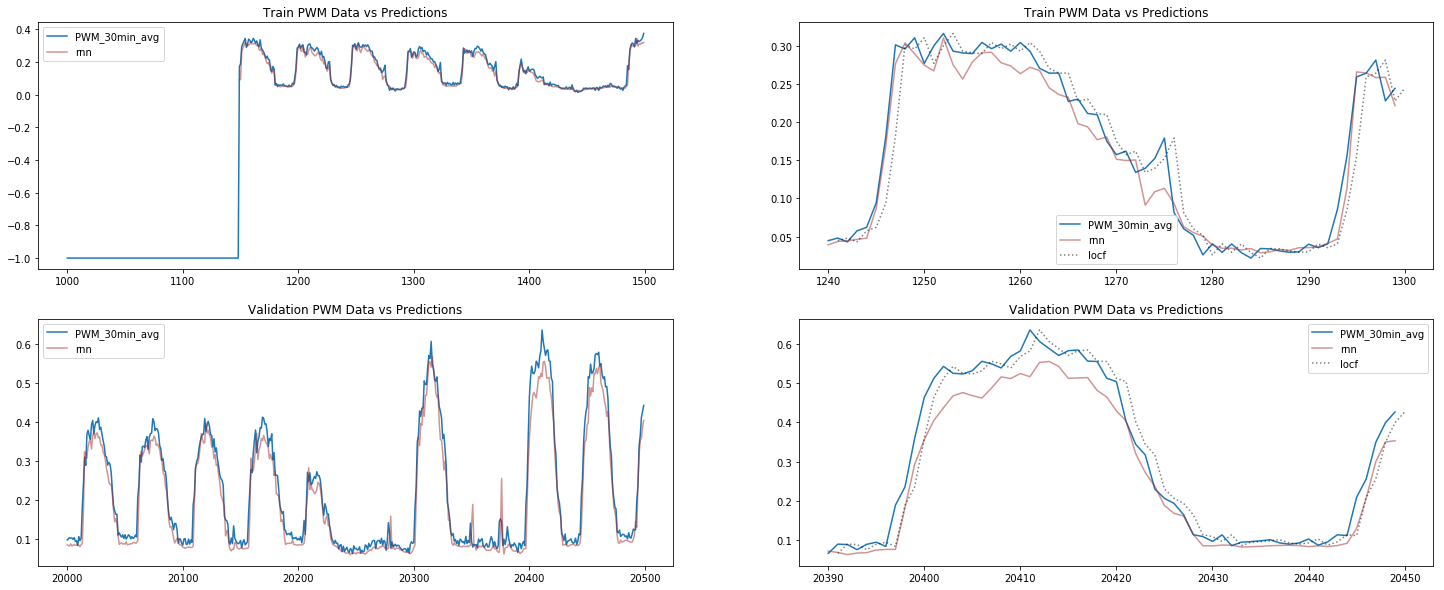

In [50]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [51]:
model.save('base-4x128gru-2x32dense-dropout0102-epch200.h5')

In [52]:
with open('base-4x128gru-2x32dense-dropout0102-epch200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## xxx Model

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002.h5'))
model.summary()

In [49]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50


Epoch 1/50


Epoch 1/50


 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8200 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.8066


Epoch 2/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.5927 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3073


Epoch 3/50


 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.7837 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.6431


Epoch 4/50


 - 88s - loss: 0.0156 - mean_absolute_percentage_error: 10.8850 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.6518


Epoch 5/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.9558 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.6858


Epoch 6/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.7372 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.1714


Epoch 7/50


 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.7732 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 13.9883


Epoch 8/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.8325 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.8525


Epoch 9/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6818 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.5478


Epoch 10/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.5877 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 10.5059


Epoch 11/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6209 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 9.0055


Epoch 12/50


 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.6874 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.8163


Epoch 13/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.7618 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.6641


Epoch 14/50


 - 86s - loss: 0.0153 - mean_absolute_percentage_error: 10.8102 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 9.0553


Epoch 15/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.3616 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.6982


Epoch 16/50


 - 86s - loss: 0.0152 - mean_absolute_percentage_error: 10.7154 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.9173


Epoch 17/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.5983 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 10.4649


Epoch 18/50


 - 87s - loss: 0.0152 - mean_absolute_percentage_error: 10.4986 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.0330


Epoch 19/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.5215 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 8.7426


Epoch 20/50


 - 88s - loss: 0.0150 - mean_absolute_percentage_error: 10.4415 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2467


Epoch 21/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4082 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.1361


Epoch 22/50


 - 87s - loss: 0.0151 - mean_absolute_percentage_error: 10.3721 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.8795


Epoch 23/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.3732 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.9106


Epoch 24/50


 - 87s - loss: 0.0148 - mean_absolute_percentage_error: 10.2422 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.3097


Epoch 25/50


 - 87s - loss: 0.0150 - mean_absolute_percentage_error: 10.4804 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 9.3111


Epoch 26/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.2715 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 11.2292


Epoch 27/50


 - 87s - loss: 0.0149 - mean_absolute_percentage_error: 10.4135 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 8.9801


Epoch 28/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2207 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.8305


Epoch 29/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.2066 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 10.1136


Epoch 30/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.0973 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 12.1086


Epoch 31/50


 - 86s - loss: 0.0148 - mean_absolute_percentage_error: 10.2487 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 9.3236


Epoch 32/50


 - 86s - loss: 0.0146 - mean_absolute_percentage_error: 10.0608 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 10.5951


Epoch 33/50


 - 87s - loss: 0.0146 - mean_absolute_percentage_error: 10.1042 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.2985


Epoch 34/50


 - 86s - loss: 0.0147 - mean_absolute_percentage_error: 10.2127 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.8472


Epoch 35/50


 - 87s - loss: 0.0147 - mean_absolute_percentage_error: 10.1127 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.3444


Epoch 36/50


 - 87s - loss: 0.0145 - mean_absolute_percentage_error: 9.9344 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4945


Epoch 37/50


 - 86s - loss: 0.0145 - mean_absolute_percentage_error: 10.0337 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 10.2990


Epoch 38/50


 - 86s - loss: 0.0144 - mean_absolute_percentage_error: 10.2033 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.9608


Epoch 39/50


 - 87s - loss: 0.0144 - mean_absolute_percentage_error: 10.0721 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.2719


Epoch 40/50


 - 88s - loss: 0.0145 - mean_absolute_percentage_error: 10.2058 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 10.1445


Epoch 41/50


 - 88s - loss: 0.0144 - mean_absolute_percentage_error: 9.9969 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.9810


Epoch 42/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.9378 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 9.0890


Epoch 43/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9270 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 10.5699


Epoch 44/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8470 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 10.4775


Epoch 45/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.9480 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.6116


Epoch 46/50


 - 87s - loss: 0.0143 - mean_absolute_percentage_error: 9.8142 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.4486


Epoch 47/50


 - 87s - loss: 0.0141 - mean_absolute_percentage_error: 9.8870 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.4787


Epoch 48/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 9.7393 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.8748


Epoch 49/50


 - 87s - loss: 0.0140 - mean_absolute_percentage_error: 9.7657 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.9728


Epoch 50/50


 - 87s - loss: 0.0142 - mean_absolute_percentage_error: 10.0320 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.9776



Training Duration = 1:12:26.506771


In [50]:
# histories = []  ## if first training session
histories.append(history.history)

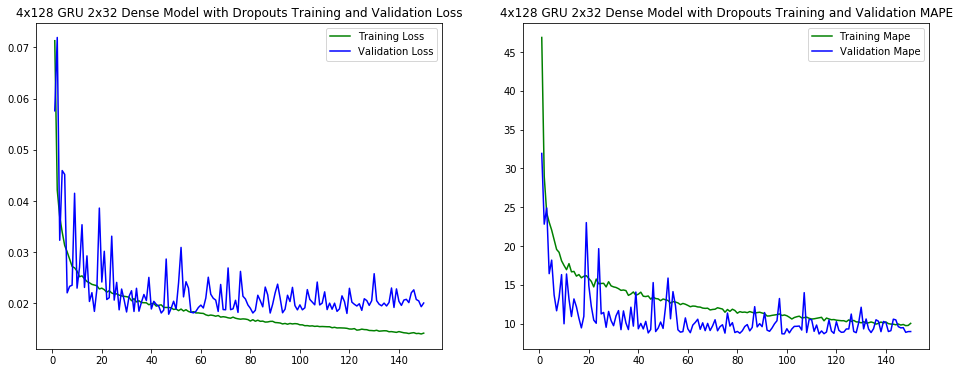

In [51]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.493735
Validation MAE = 1.904215


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

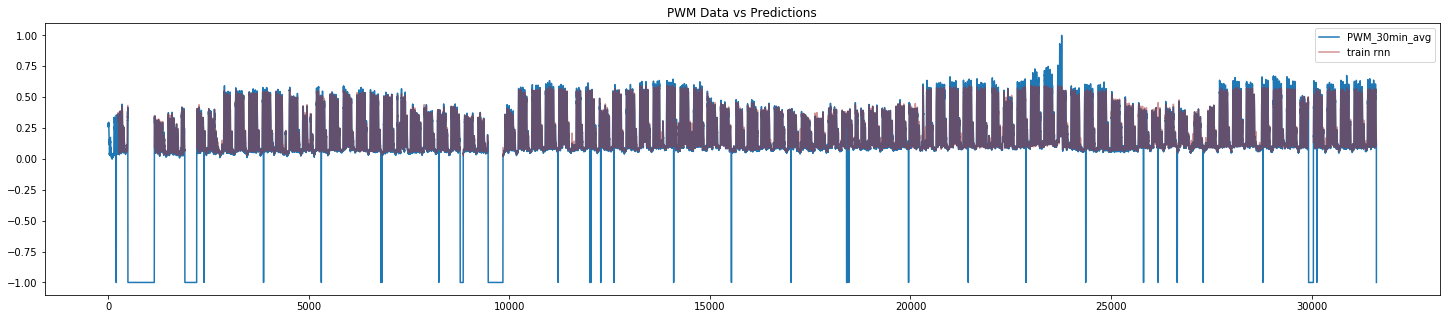

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

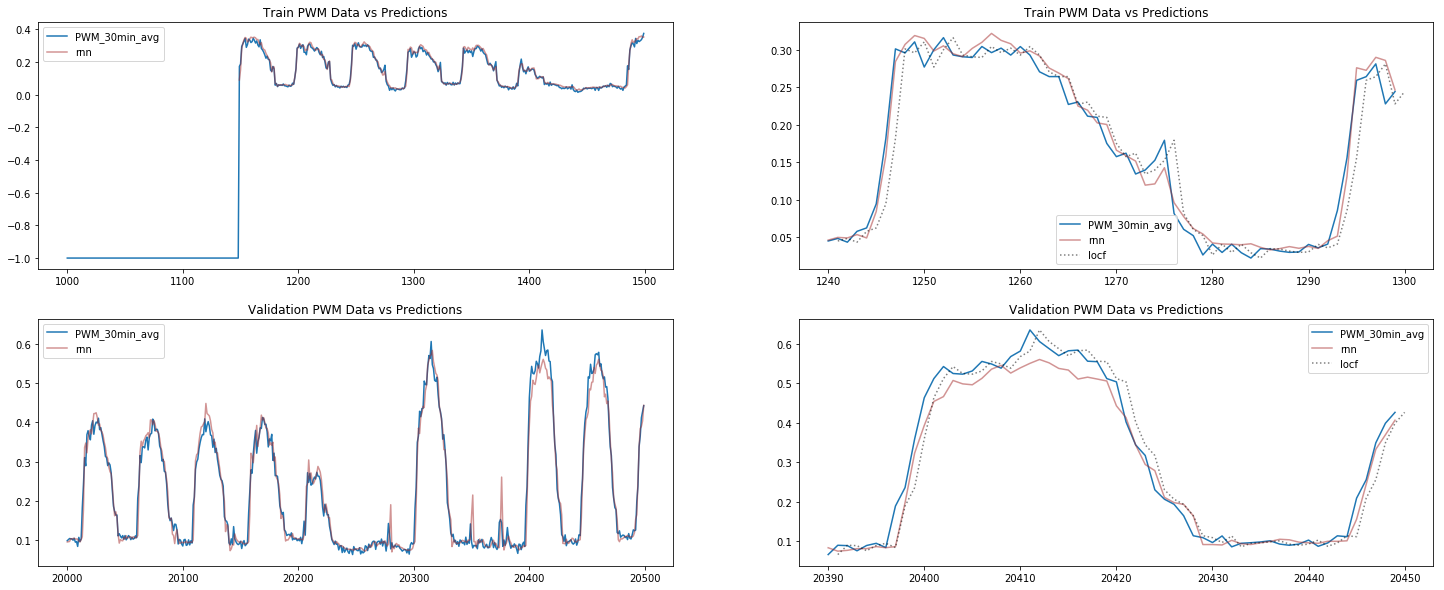

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0002.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0002-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)